In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
raw_data = {
    '1': ['normalized_data/eyebrows/eyebrows_1.csv', 'roi_v2/eyebrows/eyebrows_1.csv'],
    '2': ['normalized_data/eyebrows/eyebrows_2.csv', 'roi_v2/eyebrows/eyebrows_2.csv'],
    '3': ['normalized_data/eyebrows/eyebrows_3.csv', 'roi_v2/eyebrows/eyebrows_3.csv'],
    '4': ['normalized_data/eyebrows/eyebrows_4.csv', 'roi_v2/eyebrows/eyebrows_4.csv'],
    '5': ['normalized_data/eyebrows/eyebrows_5.csv', 'roi_v2/eyebrows/eyebrows_5.csv'],
    '6': ['normalized_data/eyebrows/eyebrows_6.csv', 'roi_v2/eyebrows/eyebrows_6.csv'],
    '7': ['normalized_data/eyebrows/eyebrows_7.csv', 'roi_v2/eyebrows/eyebrows_7.csv'],
    '8': ['normalized_data/eyebrows/eyebrows_8.csv', 'roi_v2/eyebrows/eyebrows_8.csv'],
    '9': ['normalized_data/eyebrows/eyebrows_9.csv', 'roi_v2/eyebrows/eyebrows_9.csv'],
    '10': ['normalized_data/eyebrows/eyebrows_10.csv', 'roi_v2/eyebrows/eyebrows_10.csv'],
}

In [3]:
def process_raw_record(args):
    input_path = args[0]
    label_path = args[1]

    input_df = pd.read_csv(input_path).drop(columns=['Unnamed: 0'])
    input_data = input_df.to_numpy()

    label_df = pd.read_csv(label_path).to_numpy()
    label = np.zeros(len(input_data))
    for row in label_df:
        label[row[0]:row[1]] = row[2]

    return input_data, label

# data, label = process_raw_record(raw_data['blink_both'])
# data.shape, label.shape

In [4]:
def create_dataset(x, y, time_step=128):
    assert x.shape[0] == y.shape[0]
    x_new = []
    y_new = []

    epsilon = 0.1

    # Not overlap
    # for i in range(0, x.shape[0] // time_step * time_step, time_step):
    # Overlap
    for i in range(0, x.shape[0] - time_step):
        if 1 in y[i:i+time_step] or np.random.random() < epsilon:
            x_new.append(x[i:i+time_step])
            y_new.append(y[i:i+time_step])
    
    return np.array(x_new), np.array(y_new)

In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
from scipy.signal import medfilt # import the median filter function
def median(signal):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D
#notch filter apllied at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 256#1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data


In [7]:
def do_filter(x):
    x=median(x) # apply 3rd order median filter and store the filtred signal in med_filtred
    fs = 256
    lowcut = 20
    highcut = 49
    
    x=butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
    x=savgol_filter(x, 10, polyorder=5 ,mode='nearest')
    #x=Implement_Notch_Filter(0.02, 1, 50, 1, 2, 'butter',x)
    # x=denoise_wavelet(x,method='BayesShrink',mode='hard',wavelet='sym5',wavelet_levels=5,rescale_sigma=True)
    return x

In [8]:
# def filter(x):
#     for 

In [9]:
dataset = {}
for label_ in raw_data:
    data, label = process_raw_record(raw_data[label_])

    # Train test split
    dataset[label_] = {}

    temp_data, temp_label = create_dataset(data, label)
    # temp_data = filter(temp_data)
    temp_data, temp_label = unison_shuffled_copies(temp_data, temp_label)
    # print(temp_data.shape, temp_label.shape)
    train_idx = int(temp_data.shape[0] * 0.8)
    dataset[label_]['train_data'] = temp_data[:train_idx]
    dataset[label_]['train_label'] = temp_label[:train_idx]
    dataset[label_]['test_data'] = temp_data[train_idx:]
    dataset[label_]['test_label'] = temp_label[train_idx:]

    print(
        label_, 
        dataset[label_]['train_data'].shape,
        dataset[label_]['train_label'].shape,
        dataset[label_]['test_data'].shape,
        dataset[label_]['test_label'].shape,
        sep='\n'
    )

1
(2819, 128, 4)
(2819, 128)
(705, 128, 4)
(705, 128)
2
(2886, 128, 4)
(2886, 128)
(722, 128, 4)
(722, 128)
3
(2864, 128, 4)
(2864, 128)
(717, 128, 4)
(717, 128)
4
(2912, 128, 4)
(2912, 128)
(729, 128, 4)
(729, 128)
5
(2892, 128, 4)
(2892, 128)
(723, 128, 4)
(723, 128)
6
(2972, 128, 4)
(2972, 128)
(744, 128, 4)
(744, 128)
7
(2917, 128, 4)
(2917, 128)
(730, 128, 4)
(730, 128)
8
(2921, 128, 4)
(2921, 128)
(731, 128, 4)
(731, 128)
9
(2869, 128, 4)
(2869, 128)
(718, 128, 4)
(718, 128)
10
(2923, 128, 4)
(2923, 128)
(731, 128, 4)
(731, 128)


In [10]:
# Concatenate data 
train_x = []
train_y = []
test_x = []
test_y = []

for label in dataset:
    train_x.append(dataset[label]['train_data'])
    train_y.append(dataset[label]['train_label'])
    test_x.append(dataset[label]['test_data'])
    test_y.append(dataset[label]['test_label'])

train_x = np.concatenate(train_x)#[:, :, [0, 3]]
train_y = np.concatenate(train_y)
test_x = np.concatenate(test_x)#[:, :, [0, 3]]
test_y = np.concatenate(test_y)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((28975, 128, 4), (28975, 128), (7250, 128, 4), (7250, 128))

In [11]:
train_x = train_x.transpose((0, 2, 1))
test_x = test_x.transpose((0, 2, 1))

train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((28975, 4, 128, 1), (28975, 128), (7250, 4, 128, 1), (7250, 128))

In [12]:
train_x, train_y = unison_shuffled_copies(train_x, train_y)

In [13]:
train_x.shape

(28975, 4, 128, 1)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from models.EEGNet import *

In [15]:
# base_model = EEGNet(
#     nb_classes=1, Chans = 4, Samples = 128, 
#     dropoutRate = 0.5, kernLength = 50, F1 = 32, 
#     D = 2, F2 = 64, norm_rate = 0.25, dropoutType = 'Dropout'
# )
base_model = EEGNet_SSVEP(
    nb_classes = 1, Chans = 4, Samples = 128, 
    dropoutRate = 0.5, kernLength = 50, F1 = 96, 
    D = 1, F2 = 96, dropoutType = 'Dropout'
)

d:\FPTU\THESIS\thesis\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
x = base_model.layers[-3].output
x = Dense(128*2, activation='relu')(x)
x = Reshape((128, 2))(x)
x = Activation('softmax', name = 'softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 128, 96)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 128, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 128, 96)     │           384 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 128, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 128, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 32, 96)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 32, 96)      │        10,752 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 32, 96)      │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 32, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 96)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 128, 2)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,648 (451.75 KB)

 Trainable params: 115,072 (449.50 KB)

 Non-trainable params: 576 (2.25 KB)

In [17]:
history = model.fit(
    train_x, 
    train_y,
    epochs=50,
    validation_data=(test_x, test_y),
)

Epoch 1/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8737 - loss: 0.2872 - val_accuracy: 0.6701 - val_loss: 0.9074
Epoch 2/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9441 - loss: 0.1414 - val_accuracy: 0.9475 - val_loss: 0.1452
Epoch 3/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9491 - loss: 0.1267 - val_accuracy: 0.9557 - val_loss: 0.1073
Epoch 4/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9509 - loss: 0.1205 - val_accuracy: 0.8705 - val_loss: 0.3020
Epoch 5/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9544 - loss: 0.1126 - val_accuracy: 0.9610 - val_loss: 0.0975
Epoch 6/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9549 - loss: 0.1104 - val_accuracy: 0.9516 - val_loss: 0.1544
Epoch 7/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9572 - loss: 0.1050 - val_accuracy: 0.9595 - val_loss: 0.0990
Epoch 8/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9573 - loss: 0.1043 - 

In [26]:
model.save_weights(r'.\checkpoints\eyebrows\eegnet_ssvep_v1.weights.h5')

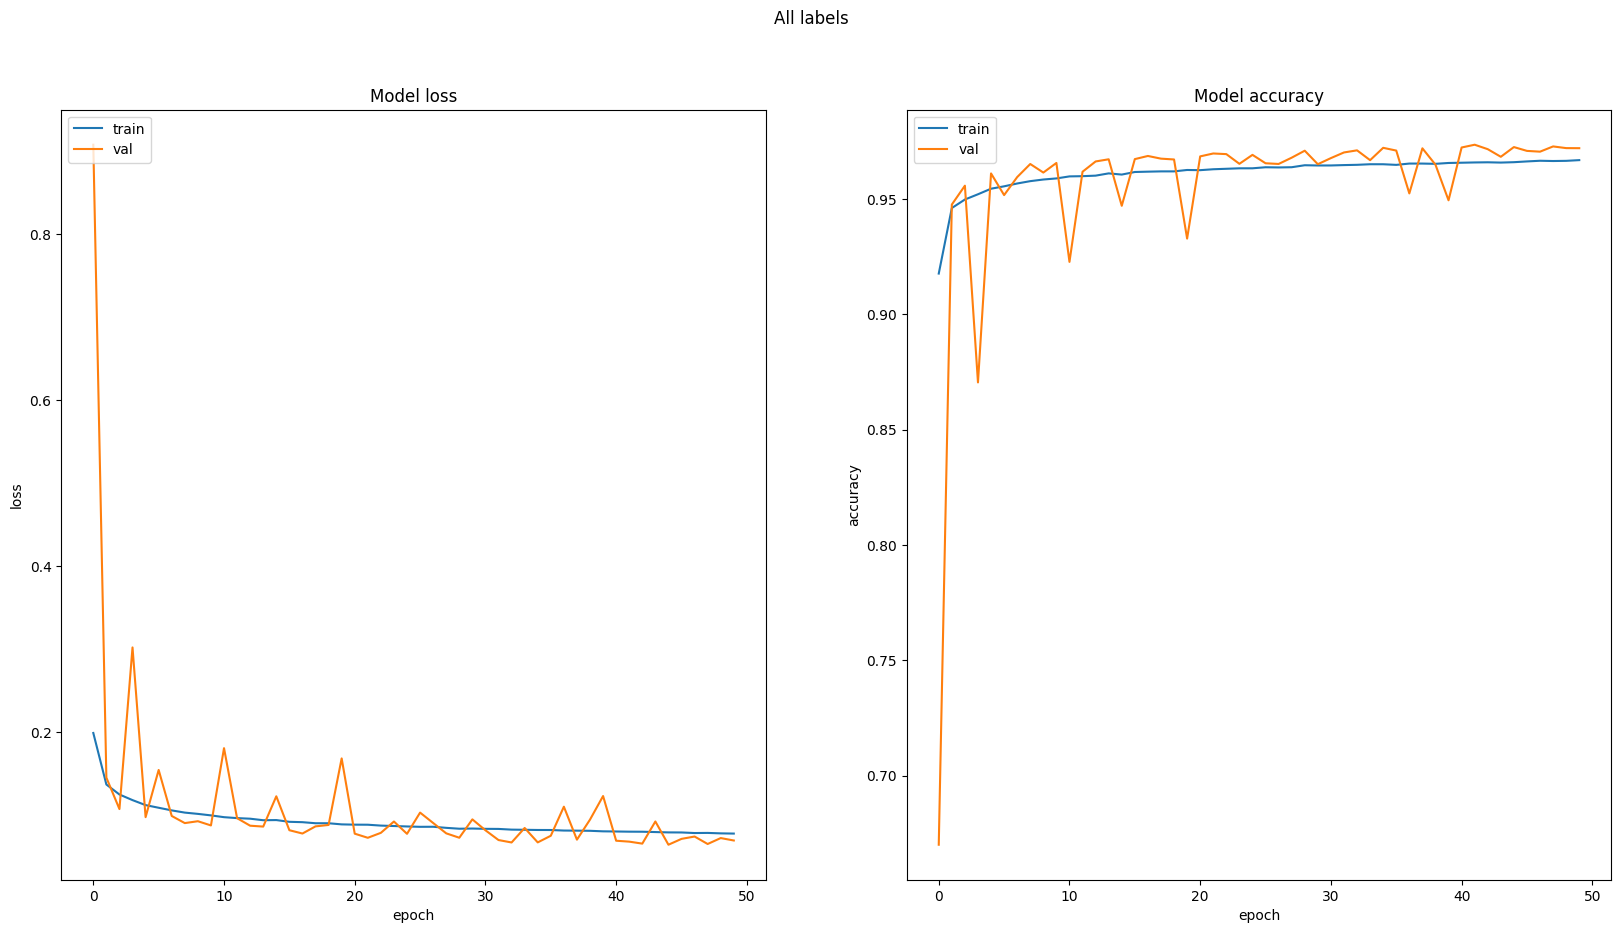

In [27]:
plt.figure(figsize=(20, 10)).suptitle("All labels")
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [28]:
y_pred = model.predict(test_x)
# y_pred.shape, np.argmax(y_pred, 2)[0], np.argmax(test_y[i], 1)
y_pred.shape

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(7250, 128, 2)

In [29]:
y_true = test_y
y_pred = np.argmax(y_pred, 2)
y_true.shape, y_pred.shape

((7250, 128), (7250, 128))

In [30]:
from sklearn.metrics import confusion_matrix

cm_total = np.zeros((2, 2))

for y_t, y_p in zip(y_true, y_pred):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1])
    cm = np.array(cm)
    cm_total = cm_total + cm

cm_total


array([[700819.,   8640.],
       [ 17363., 201178.]])

In [31]:
result = []
for cls in range(2):
    tp = cm_total[cls, cls]
    fn = np.sum(np.delete(cm_total[cls, :], cls))
    fp = np.sum(np.delete(cm_total[:, cls], cls))
    tn = np.delete(cm_total, cls, axis=0)
    tn = np.sum(np.delete(tn, cls, axis=1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + fn + tn + fp)
    specifity = tn/(tn+fp)

    result.append([precision, recall, f1, acc, specifity])

print('precision, recall, f1, acc, specifity')
result = np.array(result)
result

precision, recall, f1, acc, specifity


array([[0.97582368, 0.98782171, 0.98178604, 0.97197953, 0.92055038],
       [0.95882145, 0.92055038, 0.93929624, 0.97197953, 0.98782171]])

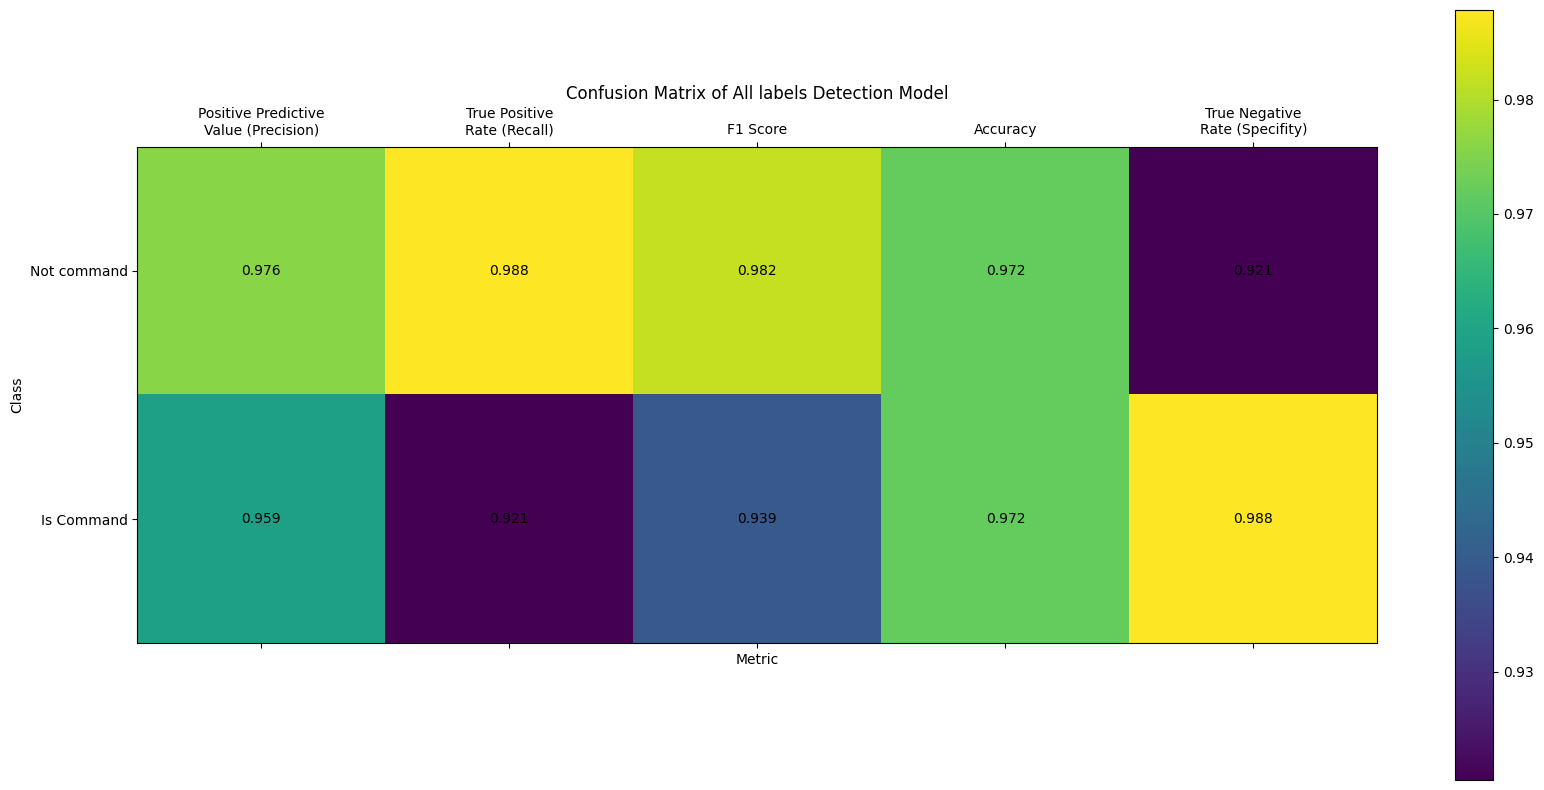

In [32]:
plt.figure(figsize=(20, 10))
plt.title("Confusion Matrix of All labels Detection Model")
plt.matshow(result, fignum=False)
plt.xticks([0, 1, 2, 3, 4], ['Positive Predictive\nValue (Precision)', 'True Positive\nRate (Recall)', 'F1 Score', 'Accuracy', 'True Negative\nRate (Specifity)'])
plt.yticks([0, 1], ['Not command', 'Is Command'])
plt.xlabel("Metric")
plt.ylabel("Class")
for (i, j), z in np.ndenumerate(result):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.colorbar()

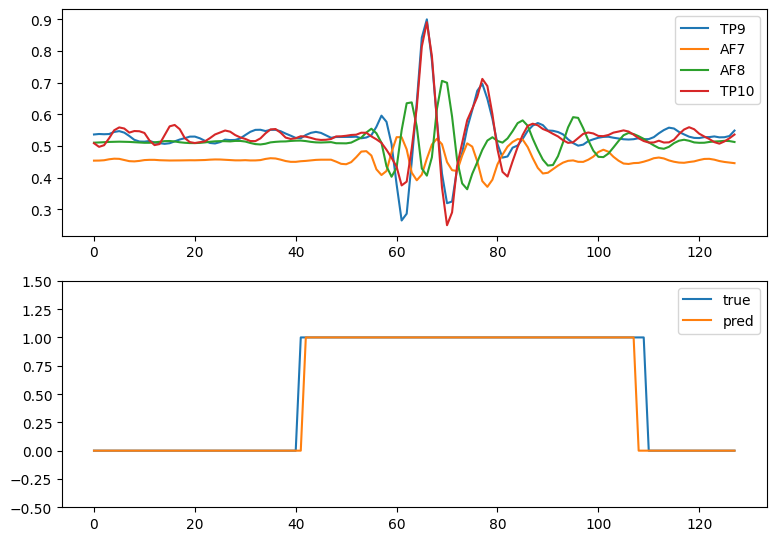

In [44]:
plt.figure(figsize=(20,10))
idx = np.random.randint(0, test_x.shape[0])
plt.subplot(3, 2, 1)
plt.plot(test_x[idx].transpose(1, 0, 2).squeeze(2), label=['TP9', 'AF7', 'AF8', 'TP10'])
plt.legend()
plt.subplot(3, 2, 3)
plt.gca().set_ylim(-0.5, 1.5)
plt.plot(test_y[idx], label='true')
plt.plot(y_pred[idx], label='pred')
plt.legend()

